# Classification

A classification problem in machine learning is one in which a class label is anticipated for a specific example of input data

### Types of Classification

#### Binary classification:

Target can be one of two options, e.g. yes or no

#### Multi-class classification:

Target can be one of more than two options

#### Multi-label classification:

Target can be assigned more than one option (Like a movie falll into different genre)

# 1) Load Dataset

In [1]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
# you can visit the above site for datasets

from sklearn.datasets import make_moons

In [2]:
x,y = make_moons(1000)

In [3]:
x.shape

(1000, 2)

In [4]:
x[:10]

array([[ 9.40225772e-01, -4.98211922e-01],
       [ 7.53308116e-01,  6.57667759e-01],
       [ 1.53412468e+00, -3.45405714e-01],
       [-8.43720163e-01,  5.36783277e-01],
       [ 9.09750838e-01,  4.15154685e-01],
       [-7.77607992e-01,  6.28749402e-01],
       [-5.60468103e-01,  8.28176011e-01],
       [ 1.34825731e+00, -4.37398978e-01],
       [ 3.17077692e-04,  4.74819554e-01],
       [ 1.94064596e+00,  1.60610568e-01]])

In [5]:
y[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [6]:
import pandas as pd
moons = pd.DataFrame({"X1": x[:, 0],
    "X2": x[:, 1],
    "label": y
})

moons.head()

,X1,X2,label
0,0.940226,-0.498212,1
1,0.753308,0.657668,0
2,1.534125,-0.345406,1
3,-0.843720,0.536783,0
4,0.909751,0.415155,0


In [7]:
# lets check the label count

moons.label.value_counts()

0    500
1    500
Name: label, dtype: int64

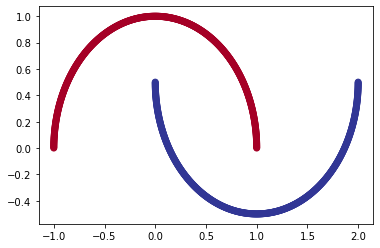

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=x[:, 0], 
            y=x[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

#### Convert data into tensors

In [9]:
import torch

x= torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5],y[:5]

(tensor([[ 0.9402, -0.4982],
         [ 0.7533,  0.6577],
         [ 1.5341, -0.3454],
         [-0.8437,  0.5368],
         [ 0.9098,  0.4152]]),
 tensor([1., 0., 1., 0., 0.]))

In [10]:
x.shape

torch.Size([1000, 2])

In [11]:

# Split data into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.3, # 30% test, 70% train
                                                    random_state=42) # make the random split reproducible

len(x_train), len(x_test), len(y_train), len(y_test)

(700, 300, 700, 300)

# 2) Build the Model



In [12]:
class MoonClassifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Define architecture
        
        self.layer1 = torch.nn.Linear(in_features=2,out_features=10)
        self.layer2 = torch.nn.Linear(in_features=10,out_features=5)
        self.layer3 = torch.nn.Linear(in_features=5,out_features=1)
        
    # Define forward method
    
    def forward(self,data):
        l1_out = self.layer1(data)
        l2_out = self.layer2(l1_out)
        l3_out = self.layer3(l2_out)
        
        return l3_out
        

In [13]:
model_0 = MoonClassifier()
model_0

MoonClassifier(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=1, bias=True)
)

#### Lets discuss architecture

As we have 2 inputs for our network we define in_features of layer1 as 2 and its output neuron are 10.

In second layer the previous 10 neuron output pass through the second layer and
its output neurions are 5.

In 3rd layer the input are 5 and the output is 1 neuron  becuase we are doing binary classification here.

### Set Loss function and Optimizer

For binary classification we use sigmoid function and Binary crossentropy loss

In [14]:
loss_fn = torch.nn.BCEWithLogitsLoss() # BCEWithLogitsLoss - BinaryCrossEntropy

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=00.1)

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3) Train Model

Model outputs 0 and 1 but wait the sigmoid function give a continous value  between 0-1. On backend what it actually does is that, 

if y_pred >= 0.5, y=1 (class 1)
if y_pred < 0.5, y=0 (class 0)

In [16]:
# Set the number of epochs
epochs = 500
epoch_count = []
testing_acc = []
training_acc = []

testing_loss = []
training_loss = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(x_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    
    
    
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 
    
    

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_0(x_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
     
       # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        
       
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
       
        
        
    # Print out what's happening every 50 epochs
    if epoch % 50 == 0:
        training_acc.append(acc)
        testing_acc.append(test_acc)
        
        training_loss.append(loss)
        testing_loss.append(test_loss)
        
        epoch_count.append(epoch)
        
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74980, Accuracy: 29.57% | Test loss: 0.73445, Test acc: 36.33%
Epoch: 50 | Loss: 0.47057, Accuracy: 76.00% | Test loss: 0.47477, Test acc: 73.00%
Epoch: 100 | Loss: 0.27967, Accuracy: 86.00% | Test loss: 0.31333, Test acc: 82.67%
Epoch: 150 | Loss: 0.23490, Accuracy: 88.86% | Test loss: 0.27458, Test acc: 86.33%
Epoch: 200 | Loss: 0.22639, Accuracy: 89.57% | Test loss: 0.26835, Test acc: 87.33%
Epoch: 250 | Loss: 0.22481, Accuracy: 89.71% | Test loss: 0.26778, Test acc: 87.33%
Epoch: 300 | Loss: 0.22449, Accuracy: 90.00% | Test loss: 0.26792, Test acc: 87.33%
Epoch: 350 | Loss: 0.22442, Accuracy: 90.00% | Test loss: 0.26806, Test acc: 87.33%
Epoch: 400 | Loss: 0.22441, Accuracy: 90.00% | Test loss: 0.26814, Test acc: 87.33%
Epoch: 450 | Loss: 0.22441, Accuracy: 90.00% | Test loss: 0.26819, Test acc: 87.33%


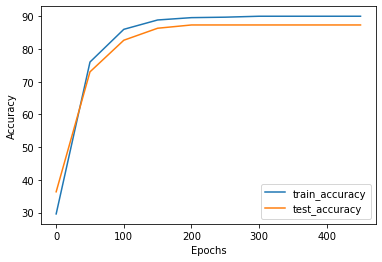

In [17]:
plt.plot(epoch_count,training_acc,label='train_accuracy')
plt.plot(epoch_count,testing_acc,label='test_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

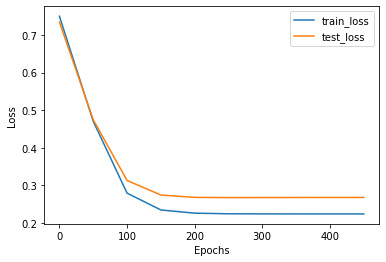

In [18]:
plt.plot(epoch_count,training_loss,label='train_loss')
plt.plot(epoch_count,testing_loss,label='test_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### We can also increase the number of layers, epochsm activation functions and other hyperparameter to increase its accuracy.

# Multi Class Classification

## Load Dataset

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


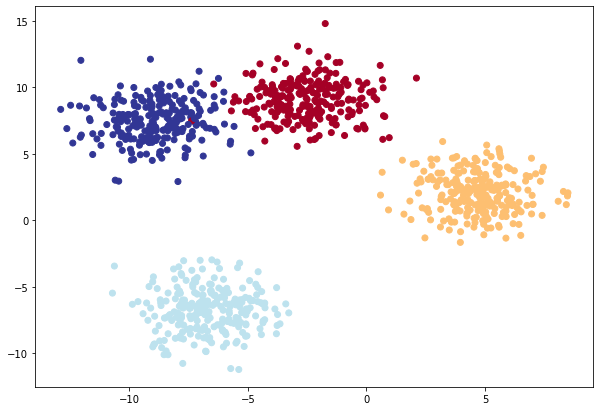

In [19]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Convert data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.3,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Build Model

In [20]:
class BlobsModel(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features=NUM_FEATURES,out_features=20)
        # Add Relu layer for NonLinearity 
        # ReLu : max(0,input)
        
        self.relu1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(in_features=20,out_features=10)
        
        self.relu2= torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(in_features=10,out_features=4)
        
    def forward(self,X):
        l1 = self.layer1(X)
        r1 = self.relu1(l1)
        l2 = self.layer2(r1)
        r2 = self.relu2(l2)
        l3 = self.layer3(r2)
        
        return l3
        
        
        

In [21]:
model_1 = BlobsModel()
model_1

BlobsModel(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=20, out_features=10, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=10, out_features=4, bias=True)
)

In [22]:
# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), 
                            lr=00.1)

In [23]:
X_blob_train.shape

torch.Size([700, 2])

In [24]:
y_pred.shape

torch.Size([700])

# Train Model

In [25]:
# Set the number of epochs
epochs = 500
epoch_count = []
testing_acc = []
training_acc = []

testing_loss = []
training_loss = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_1(X_blob_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    
    # here we use Softmax function for multi class classification

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_blob_train) 
    
    
    
    acc = accuracy_fn(y_true=y_blob_train, 
                      y_pred=y_pred) 
    
    

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_1(X_blob_test).squeeze() 
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
     
       # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_blob_test)
        
       
        
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
       
        
        
    # Print out what's happening every 50 epochs
    if epoch % 50 == 0:
        training_acc.append(acc)
        testing_acc.append(test_acc)
        
        training_loss.append(loss)
        testing_loss.append(test_loss)
        
        epoch_count.append(epoch)
        
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.44597, Accuracy: 24.71% | Test loss: 1.00163, Test acc: 52.67%
Epoch: 50 | Loss: 0.04683, Accuracy: 99.00% | Test loss: 0.03394, Test acc: 99.33%
Epoch: 100 | Loss: 0.03399, Accuracy: 99.14% | Test loss: 0.02187, Test acc: 99.33%
Epoch: 150 | Loss: 0.03053, Accuracy: 99.14% | Test loss: 0.01846, Test acc: 99.33%
Epoch: 200 | Loss: 0.02892, Accuracy: 99.14% | Test loss: 0.01679, Test acc: 99.33%
Epoch: 250 | Loss: 0.02797, Accuracy: 99.14% | Test loss: 0.01579, Test acc: 99.33%
Epoch: 300 | Loss: 0.02729, Accuracy: 99.14% | Test loss: 0.01511, Test acc: 99.33%
Epoch: 350 | Loss: 0.02677, Accuracy: 99.14% | Test loss: 0.01462, Test acc: 99.33%
Epoch: 400 | Loss: 0.02633, Accuracy: 99.14% | Test loss: 0.01424, Test acc: 99.33%
Epoch: 450 | Loss: 0.02596, Accuracy: 99.14% | Test loss: 0.01393, Test acc: 99.33%


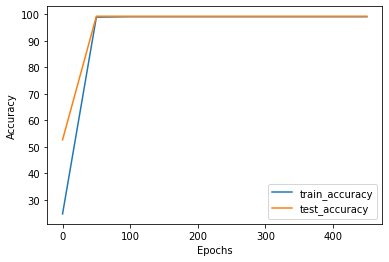

In [26]:
plt.plot(epoch_count,training_acc,label='train_accuracy')
plt.plot(epoch_count,testing_acc,label='test_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

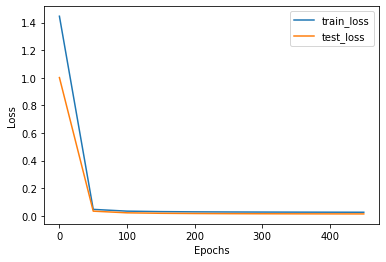

In [27]:
plt.plot(epoch_count,training_loss,label='train_loss')
plt.plot(epoch_count,testing_loss,label='test_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# The End